## Post-deployment QA: Reply tool v2.0 instrumentation (DB) [T252930](https://phabricator.wikimedia.org/T252930)

## Part 1 : Discussion Tools QA


This task is about ensuring that the newly added events and fields are being logged correctly in database.

Test scenarios are documented in this [QC document](https://docs.google.com/spreadsheets/d/1txtypYKZHCiZEFnkye9LX7riF3VEippMmvN6ILs_BUQ/edit#gid=605234531)

**Observations:**
- All the Discussion Tools data in EditAttemptStep and VisualEditorFeatureUse looks good
- saveFailure and Abort events are quite low. Overall the tool seems to have a good success ratio
- Discussion Tools are deployed to 12 wikis currently : [Deployment Status](https://www.mediawiki.org/wiki/Talk_pages_project/replying#Deployment_status)
 - Arabic
 - Dutch
 - French
 - Hungarian
 - Chinese
 - Czech
 - Serbian
 - Georgian
 - Sorani Kurdish
 - Swedish
 - Catalan
 - Korean

However, we do see DT events for other wikis, but the number of events in those wikis are few in number and hence not a big issue.  

- As expected, there are no events in any other platform other than "Desktop" since Replying feature is currently deployed only to desktop
- Since Replying is an Opt-in Beta Feature currently, there are no events with logged out users
- Looking at the edit count bucket, it seems like a majority of the users trying the Reply tool are experienced editors
- On a given day in all the wikis, users are not switching between source mode and visual mode a whole lot 
- Overall it seems like users prefer to tag someone in a coversation by Typing @ in the Reply tool's visual mode (inside the text box) instead of clicking the icon "👤 " from the visual mode's toolbar
- Very few users who have opted to "Watch" a Discussion are using the Checkbox for watching a page
- Overall we do not see a lot of Styling changes made by users. This could be because this is a Talk page edit and not an Article edit and doesnt need a whole lot of styling. 

In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import numpy as np
import pandas as pd
from tabulate import tabulate
from wmfdata import charting, hive, mariadb
from wmfdata.charting import comma_fmt, pct_fmt
from wmfdata.utils import df_to_remarkup, pct_str
import matplotlib.ticker as ticker
@ticker.FuncFormatter
def million_formatter(x, pos):
    return "%d M" % round(x/1000000)
@ticker.FuncFormatter
def thousand_formatter(x, pos):
    return "%d K" % round(x/1000)

## Schema : EditAttemptStep

In [2]:
# Count of all events in EditAttemptStep with Integration=discussiontools

count_actions_editattemptstep = hive.run("""
SELECT
  date_format(dt, "yyyy-MM-dd") AS date,
  event.action AS action,
  COUNT(*) AS events
FROM event.editattemptstep
WHERE
  year = 2020 
  AND month>=7
  AND wiki <> 'testwiki'
  AND event.integration='discussiontools'
GROUP BY date_format(dt, "yyyy-MM-dd"), event.action
""")

In [3]:
count_actions_editattemptstep_pivot=count_actions_editattemptstep.pivot(index="date",
                                    columns='action', values='events').fillna(0)

### Overall count of Events by Day and Action

In [4]:
count_actions_editattemptstep_pivot.head()

action,abort,firstChange,init,loaded,ready,saveAttempt,saveFailure,saveIntent,saveSuccess
date,,,,,,,,,
2020-07-01,6.0,21.0,21.0,20.0,20.0,15.0,0.0,15.0,15.0
2020-07-02,6.0,11.0,15.0,14.0,14.0,9.0,0.0,9.0,9.0
2020-07-03,2.0,29.0,23.0,23.0,23.0,20.0,0.0,20.0,20.0
2020-07-04,4.0,13.0,13.0,13.0,13.0,9.0,0.0,9.0,9.0
2020-07-05,6.0,24.0,24.0,23.0,23.0,16.0,0.0,16.0,16.0


In [5]:
count_actions_editattemptstep_pivot=count_actions_editattemptstep_pivot.reset_index()

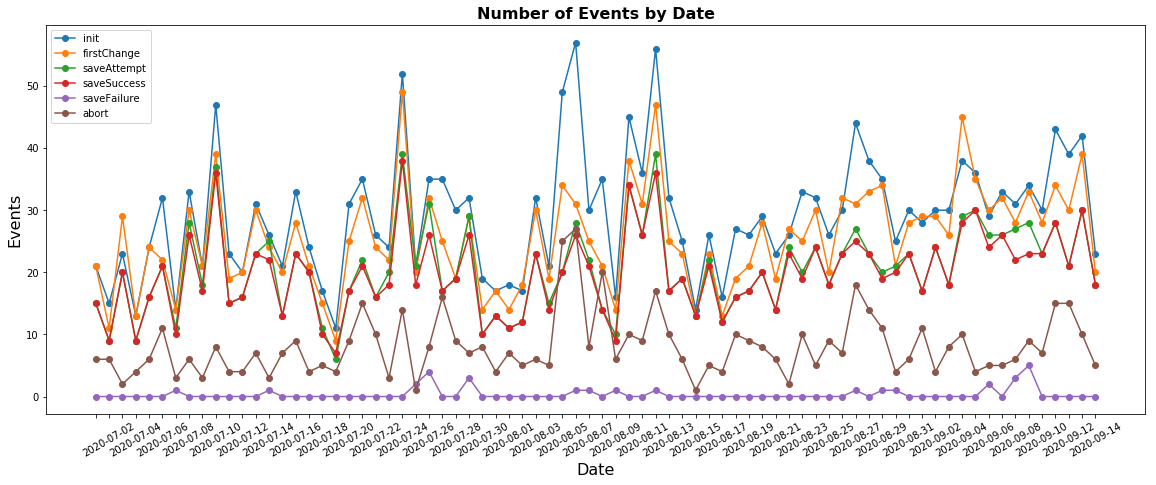

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(16,6))
fig.tight_layout(pad=1.08, w_pad=0.5, h_pad=6)
ax.set_title('Number of Events by Date',fontweight="bold",fontsize = 16)
ax.set_xlabel('Date',  fontsize = 16)
ax.set_ylabel('Events',  fontsize = 16)
ax.plot(count_actions_editattemptstep_pivot["date"], 
        count_actions_editattemptstep_pivot['init'], 'o-', label='init')
ax.plot(count_actions_editattemptstep_pivot["date"], 
        count_actions_editattemptstep_pivot['firstChange'], 'o-', label='firstChange')
ax.plot(count_actions_editattemptstep_pivot["date"], 
        count_actions_editattemptstep_pivot['saveAttempt'], 'o-', label='saveAttempt')
ax.plot(count_actions_editattemptstep_pivot["date"], 
        count_actions_editattemptstep_pivot['saveSuccess'], 'o-', label='saveSuccess')
ax.plot(count_actions_editattemptstep_pivot["date"], 
        count_actions_editattemptstep_pivot['saveFailure'], 'o-', label='saveFailure')
ax.plot(count_actions_editattemptstep_pivot["date"], 
        count_actions_editattemptstep_pivot['abort'], 'o-', label='abort')
plt.xticks(rotation=30)  
#ax.yaxis.set_major_formatter(thousand_formatter)
ax.legend(loc='upper left')
spacing = 2
for label in ax.xaxis.get_ticklabels()[::spacing]:
    label.set_visible(False)
plt.show()

In [7]:
# Count of all events in EditAttemptStep with Integration=discussiontools

count_actions_eas = hive.run("""
SELECT
 -- date_format(dt, "yyyy-MM-dd") AS date,
  event.action AS action,
  COUNT(*) AS events
FROM event.editattemptstep
WHERE
  year = 2020 
  AND month>=7
  AND wiki <> 'testwiki'
  AND event.integration='discussiontools'
GROUP BY event.action
""")

In [8]:
count_actions_eas=count_actions_eas.set_index('action')

### Count of Events by Action

In [9]:
count_actions_eas

,events
action,
loaded,1644
saveAttempt,1230
firstChange,1528
saveIntent,1228
saveFailure,18
abort,501
init,1774
saveSuccess,1192
ready,1644


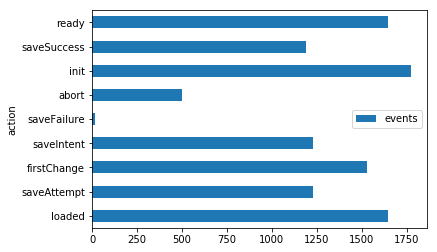

In [10]:
ax=count_actions_eas.plot.barh()

saveFailure and Abort events are considerably low. Overall the tool seems to have a good success ratio

In [11]:
# Count of all events in EditAttemptStep with Integration=discussiontools

count_actions_eas_wiki = hive.run("""
SELECT
  wiki,
--  event.action AS action,
  COUNT(*) AS events
FROM event.editattemptstep
WHERE
  year = 2020 
  AND month>=7
  AND wiki <> 'testwiki'
  AND event.integration='discussiontools'
GROUP BY wiki
""")

Discussion Tools are deployed to 12 wikis currently : [Deployment Status](https://www.mediawiki.org/wiki/Talk_pages_project/replying#Deployment_status)
- Arabic
- Dutch
- French
- Hungarian
- Chinese
- Czech
- Serbian
- Georgian
- Sorani Kurdish
- Swedish
- Catalan
- Korean

However, we do see DT events for other wikis, but the number of events in those wikis are few in number and hence not a big issue.  

### Count of Events by Wiki

In [12]:
count_actions_eas_wiki.sort_values(by='events', ascending=False)

,wiki,events
1,arwiki,3330
7,frwiki,3218
12,nlwiki,1362
8,huwiki,1029
16,zhwiki,499
11,kowiki,369
5,enwiki,265
3,cswiki,252
21,mediawikiwiki,76
19,metawiki,62


In [13]:
# Count of all events in EditAttemptStep with Integration=discussiontools

count_actions_eas_platform = hive.run("""
SELECT
  event.platform AS platform,
--  event.action AS action,
  COUNT(*) AS events
FROM event.editattemptstep
WHERE
  year = 2020 
  AND month>=7
  AND wiki <> 'testwiki'
  AND event.integration='discussiontools'
GROUP BY event.platform
""")

### Count of Events by Platform
As expected, there are no events in any other platform other than "Desktop" since Replying feature is currently deployed only to desktop

In [14]:
count_actions_eas_platform

,platform,events
0,desktop,10759


In [15]:
# Count of all events in EditAttemptStep with Integration=discussiontools

count_actions_eas_integration = hive.run("""
SELECT
  event.integration AS integration,
  COUNT(*) AS events
FROM event.editattemptstep
WHERE
  year = 2020 
  AND month>=7
  AND wiki <> 'testwiki'
  -- AND event.integration='discussiontools'
GROUP BY event.integration
""")

### Count of Events by Integration

In [16]:
count_actions_eas_integration

,integration,events
0,page,50891646
1,discussiontools,10759


In [17]:
# Count of all events in EditAttemptStep with Integration=discussiontools

count_eas_editor_interface = hive.run("""
SELECT
  event.integration AS integration, 
  event.editor_interface AS editor_interface,
  COUNT(*) AS events
FROM event.editattemptstep
WHERE
  year = 2020 
  AND month>=7
  AND wiki <> 'testwiki'
  -- AND event.integration='discussiontools'
GROUP BY event.integration, event.editor_interface
""")

### Count of Events by editor interface and integration

In [18]:
count_eas_editor_interface.sort_values('integration')

,integration,editor_interface,events
0,discussiontools,wikitext,6576
3,discussiontools,visualeditor,4183
1,page,wikitext-2017,328211
2,page,wikitext,34266491
4,page,visualeditor,16296944


**All the Discussion Tools data in EditAttemptStep looks good**

# =========================

## Schema: VisualEditorFeatureUse
For all the new Features and Actions added for Replying V2.0 

In [19]:
# Count of all events in visualeditorfeatureuse with Integration=discussiontools

count_actions_vefu = hive.run("""
SELECT
  date_format(dt, "yyyy-MM-dd") AS date,
  event.action AS action,
  COUNT(*) AS events
FROM event.visualeditorfeatureuse
WHERE
  year = 2020 
  AND month>=7
  AND wiki <> 'testwiki'
  AND event.integration='discussiontools'
GROUP BY date_format(dt, "yyyy-MM-dd"), event.action
""")

In [20]:
count_actions_vefu_pivot=count_actions_vefu.pivot(index="date",
                                    columns='action', values='events').fillna(0)

In [21]:
count_actions_vefu_pivot.tail()

action,checkbox-wpWatchthis,context-clear,context-label,context-show,copy,cut,dialog-abort,dialog-approve,dialog-convert,dialog-done,...,search-pages-choose,search-pages-input,source-desktop,toggle-insertion,toggle-selection,visual-desktop,window-open-from-command,window-open-from-context,window-open-from-sequence,window-open-from-tool
date,,,,,,,,,,,,,,,,,,,,,
2020-08-28,0.0,0.0,0.0,6.0,0.0,0.0,2.0,0.0,0.0,5.0,...,5.0,4.0,2.0,0.0,0.0,1.0,0.0,0.0,6.0,7.0
2020-08-29,0.0,0.0,0.0,16.0,0.0,3.0,2.0,0.0,0.0,5.0,...,1.0,5.0,3.0,1.0,3.0,6.0,0.0,0.0,6.0,10.0
2020-08-30,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,6.0,0.0,0.0,2.0,2.0
2020-08-31,0.0,0.0,0.0,90.0,2.0,1.0,1.0,0.0,0.0,5.0,...,1.0,6.0,1.0,0.0,3.0,2.0,2.0,0.0,6.0,4.0
2020-09-01,0.0,0.0,0.0,16.0,1.0,1.0,0.0,0.0,0.0,4.0,...,1.0,2.0,4.0,9.0,1.0,5.0,0.0,0.0,5.0,4.0


In [8]:
# Count of all events in visualeditorfeatureuse with Integration=discussiontools

count_events_vefu = hive.run("""
SELECT
  date_format(dt, "yyyy-MM-dd") AS date,
  COUNT(*) AS events
FROM event.visualeditorfeatureuse
WHERE
  year = 2020 
  AND month>=7
  AND wiki <> 'testwiki'
  AND event.integration='discussiontools'
GROUP BY date_format(dt, "yyyy-MM-dd")
""")

In [9]:
count_events_vefu_pivot=count_events_vefu.sort_values("date")
#count_events_vefu.pivot(index="date",
 #                                   columns='events').fillna(0).sort_values("date")

In [10]:
count_events_vefu_pivot.tail()

,date,events
15,2020-09-10,26
31,2020-09-11,44
44,2020-09-12,26
53,2020-09-13,86
63,2020-09-14,55


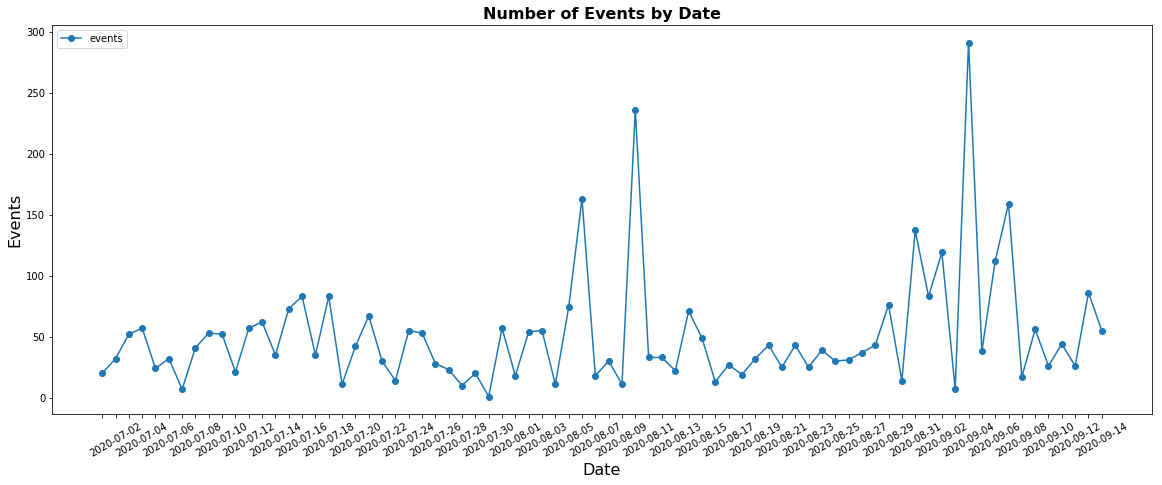

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(16,6))
fig.tight_layout(pad=1.08, w_pad=0.5, h_pad=6)
ax.set_title('Number of Events by Date',fontweight="bold",fontsize = 16)
ax.set_xlabel('Date',  fontsize = 16)
ax.set_ylabel('Events',  fontsize = 16)
ax.plot(count_events_vefu_pivot["date"], 
        count_events_vefu_pivot['events'], 'o-', label='events')

plt.xticks(rotation=30)  
#ax.yaxis.set_major_formatter(thousand_formatter)
ax.legend(loc='upper left')
spacing = 2
for label in ax.xaxis.get_ticklabels()[::spacing]:
    label.set_visible(False)
plt.show()


In [26]:
# Count of all events in visualeditorfeatureuse with Integration=discussiontools

count_feature_vefu = hive.run("""
SELECT
  date_format(dt, "yyyy-MM-dd") AS date,
  event.feature AS feature,
  COUNT(*) AS events
FROM event.visualeditorfeatureuse
WHERE
  year = 2020 
  AND month>=7
  AND wiki <> 'testwiki'
  AND event.integration='discussiontools'
GROUP BY date_format(dt, "yyyy-MM-dd"), event.feature
""")

In [27]:
count_feature_vefu_pivot=count_feature_vefu.pivot(index="date",
                                    columns='feature', values='events').fillna(0)

### Events by Feature and Date

In [28]:
count_feature_vefu_pivot.tail()

feature,citoid,clipboard,dtMwSignature,dtReply,editor-switch,findAndReplace,language,link,link/internal,link/mwNumberedExternal,...,mwSave,mwUsernameCompletion,textStyle/bold,textStyle/code,textStyle/italic,textStyle/small,textStyle/strikethrough,textStyle/superscript,transclusion,wikitextLink
date,,,,,,,,,,,,,,,,,,,,,
2020-08-28,0.0,5.0,0.0,0.0,3.0,0.0,0.0,23.0,6.0,0.0,...,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-08-29,0.0,16.0,1.0,0.0,11.0,0.0,0.0,20.0,15.0,0.0,...,0.0,9.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
2020-08-30,0.0,2.0,0.0,0.0,7.0,0.0,0.0,2.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-08-31,0.0,12.0,2.0,0.0,3.0,0.0,0.0,107.0,4.0,0.0,...,0.0,6.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
2020-09-01,0.0,7.0,1.0,0.0,10.0,0.0,0.0,11.0,15.0,0.0,...,0.0,5.0,0.0,0.0,9.0,0.0,0.0,1.0,0.0,0.0


### Count of events by Platform 

In [29]:
# Count of all events in visualeditorfeatureuse with Integration=discussiontools

count_vefu_dt_platform = hive.run("""
SELECT
  --date_format(dt, "yyyy-MM-dd") AS date,
  event.platform AS platform,
  COUNT(*) AS events
FROM event.visualeditorfeatureuse
WHERE
  year = 2020 
  AND month>=7
  AND wiki <> 'testwiki'
  AND event.integration='discussiontools'
GROUP BY --date_format(dt, "yyyy-MM-dd"), 
event.platform
""")

In [30]:
count_vefu_dt_platform

,platform,events
0,desktop,2801


DiscussionTools is currently available only on desktop web

### Count of events by editor interface

In [31]:
# Count of all events in visualeditorfeatureuse with Integration=discussiontools

count_vefu_dt_interface = hive.run("""
SELECT
  wiki AS wiki,
  event.editor_interface AS interface,
  COUNT(*) AS events
FROM event.visualeditorfeatureuse
WHERE
  year = 2020 
  AND month>=7
  AND wiki <> 'testwiki'
  AND event.integration='discussiontools'
GROUP BY wiki, event.editor_interface
""")

In [32]:
count_vefu_dt_interface

,wiki,interface,events
0,arwiki,visualeditor,1021
1,ckbwiki,wikitext,5
2,cswiki,visualeditor,14
3,dewiki,wikitext,1
4,enwiki,wikitext,2
5,eswiki,wikitext,1
6,idwiki,visualeditor,2
7,kowiki,visualeditor,92
8,mediawikiwiki,visualeditor,189
9,nlwiki,wikitext,24


### Count of events by logged in vs logged out users

In [33]:
# Count of all events in visualeditorfeatureuse with Integration=discussiontools

count_vefu_dt_userid = hive.run("""
SELECT
  wiki,
  sum(cast(event.user_id!=0 as int)) as logged_in_users,
  sum(cast(event.user_id=0 as int)) as logged_out_users
FROM event.visualeditorfeatureuse
WHERE
  year = 2020 
  AND month>=7
  AND wiki <> 'testwiki'
  AND event.integration='discussiontools'
GROUP BY wiki
""")

In [34]:
count_vefu_dt_userid.sort_values(by='logged_in_users', ascending=False)

,wiki,logged_in_users,logged_out_users
9,arwiki,1072,0
15,frwiki,799,0
2,nlwiki,236,0
5,mediawikiwiki,193,0
13,enwiki,157,0
1,kowiki,96,0
16,huwiki,57,0
14,eswiki,55,0
17,zhwiki,49,0
12,dewiki,34,0


Since Replying is an Opt-in Beta Feature, there are no events with logged out users

### Count of events by user edit count bucket

In [15]:
# Count of all events in visualeditorfeatureuse with Integration=discussiontools

count_vefu_dt_editcount = hive.run("""
SELECT
  wiki, 
  sum(cast(event.user_editcount=0 as int)) as users_no_edits,
  sum(cast(event.user_editcount>0 and event.user_editcount < 11 as int)) as users_1to10_edits,
  sum(cast(event.user_editcount>10 and event.user_editcount < 100 as int)) as users_11to99_edits,
  sum(cast(event.user_editcount>99 as int)) as users_greater99_edits
FROM event.visualeditorfeatureuse
WHERE
  year = 2020 
  AND month>=7
  AND wiki <> 'testwiki'
  AND event.integration='discussiontools'
GROUP BY wiki
""")

In [36]:
count_vefu_dt_editcount

,wiki,users_no_edits,users_1to10_edits,users_10to99_edits,users_greater99_edits
0,specieswiki,0,0,0,2
1,kowiki,0,0,0,96
2,nlwiki,0,3,93,140
3,svwiki,0,0,0,1
4,cswiki,0,0,5,11
5,mediawikiwiki,0,2,0,191
6,metawiki,0,0,0,13
7,srwiki,1,0,0,0
8,idwiki,0,0,3,0
9,arwiki,0,0,24,1048


From the edit count bucket, it seems like a majority of the users trying the Reply tool are experienced editors

### Data - QA for Replying V2.0 features


In [37]:
# Count of all events in visualeditorfeatureuse with Integration=discussiontools

count_vefu_editorswitch = hive.run("""
SELECT
  date_format(dt, "yyyy-MM-dd") AS date,
  event.feature AS feature,
  event.action AS action,
  COUNT(*) AS events
FROM event.visualeditorfeatureuse
WHERE
  year = 2020 
  AND month>=7
  AND wiki <> 'testwiki'
  AND event.integration='discussiontools'
  AND event.feature='editor-switch'
GROUP BY date_format(dt, "yyyy-MM-dd") , event.feature , event.action
""")

In [38]:
count_vefu_editorswitch.head()

,date,feature,action,events
0,2020-07-01,editor-switch,source-desktop,3
1,2020-07-01,editor-switch,visual-desktop,3
2,2020-07-10,editor-switch,visual-desktop,1
3,2020-07-15,editor-switch,source-desktop,3
4,2020-07-15,editor-switch,visual-desktop,2


In [39]:
count_vefu_editorswitch_pivot=count_vefu_editorswitch.pivot(index='date', 
                                                            columns='action', values='events')

### Editor-Switch Feature

In [40]:
count_vefu_editorswitch_pivot.fillna(0).tail()

action,dialog-prevent-template-show,source-desktop,visual-desktop
date,,,
2020-08-28,0.0,2.0,1.0
2020-08-29,2.0,3.0,6.0
2020-08-30,0.0,1.0,6.0
2020-08-31,0.0,1.0,2.0
2020-09-01,1.0,4.0,5.0


There are very few switches happening between the 2 editing modes per day in all the wikis. Editors are not switching between source mode and visual mode a whole lot

In [41]:
# Count of all events in visualeditorfeatureuse with Integration=discussiontools

count_vefu_editorswitch_user = hive.run("""
SELECT
  date_format(dt, "yyyy-MM-dd") AS date,
  event.user_id,
  event.user_editcount,
  event.feature AS feature,
  event.action AS action,
  wiki, 
  useragent.browser_family
--  COUNT(*) AS events
FROM event.visualeditorfeatureuse
WHERE
  year = 2020 
  AND month=8 AND day=13
  AND wiki <> 'testwiki'
  AND event.integration='discussiontools'
  AND event.feature='editor-switch'
--GROUP BY date_format(dt, "yyyy-MM-dd") , event.feature , event.action
""")

In [16]:
# Count of all events in visualeditorfeatureuse with Integration=discussiontools

count_vefu_dt_editorswitch = hive.run("""
SELECT
  event.feature AS feature,
  event.action AS action,
  COUNT(*) AS events
FROM event.visualeditorfeatureuse
WHERE
  year = 2020 
  AND month>=7
  AND wiki <> 'testwiki'
  AND event.integration='discussiontools'
  AND event.feature='editor-switch'
GROUP BY event.feature , event.action
""")

In [44]:
count_vefu_dt_editorswitch

,feature,action,events
0,editor-switch,source-desktop,125
1,editor-switch,visual-desktop,128
2,editor-switch,dialog-prevent-template-show,4


In [17]:
# Count of all events in visualeditorfeatureuse with Integration=discussiontools

count_vefu_usercompletion = hive.run("""
SELECT
  date_format(dt, "yyyy-MM-dd") AS date,
  event.feature AS feature,
  event.action AS action,
  COUNT(*) AS events
FROM event.visualeditorfeatureuse
WHERE
  year = 2020 
  AND month>=7
  AND wiki <> 'testwiki'
  AND event.integration='discussiontools'
  AND event.feature='mwUsernameCompletion'
GROUP BY date_format(dt, "yyyy-MM-dd") , event.feature , event.action
""")

### mwUsernameCompletion Feature (Tag another user in the Reply)

In [46]:
count_vefu_usercompletion.tail()

,date,feature,action,events
104,2020-08-15,mwUsernameCompletion,window-open-from-sequence,2
105,2020-08-24,mwUsernameCompletion,window-open-from-sequence,3
106,2020-08-24,mwUsernameCompletion,window-open-from-tool,1
107,2020-08-29,mwUsernameCompletion,window-open-from-sequence,4
108,2020-08-29,mwUsernameCompletion,window-open-from-tool,5


In [18]:
count_vefu_usercompletion_pivot=count_vefu_usercompletion.pivot_table(index=['date'], 
                                                                columns='action', values='events').fillna(0)

In [19]:
count_vefu_usercompletion_pivot=count_vefu_usercompletion_pivot.reset_index()

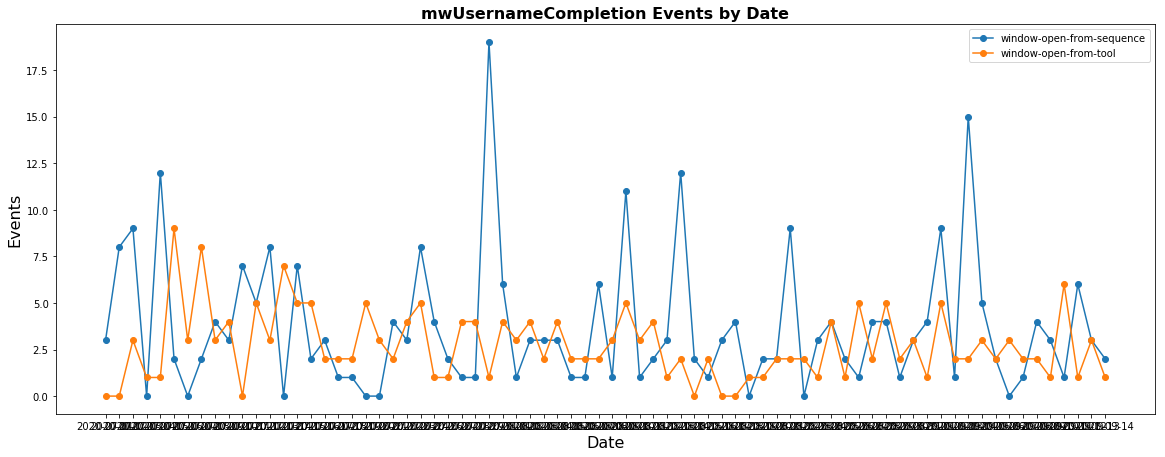

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(16,6))
fig.tight_layout(pad=1.08, w_pad=0.5, h_pad=6)
ax.set_title('mwUsernameCompletion Events by Date',fontweight="bold",fontsize = 16)
ax.set_xlabel('Date',  fontsize = 16)
ax.set_ylabel('Events',  fontsize = 16)
ax.plot(count_vefu_usercompletion_pivot["date"], 
        count_vefu_usercompletion_pivot['window-open-from-sequence'], 'o-', label='window-open-from-sequence')
ax.plot(count_vefu_usercompletion_pivot["date"], 
        count_vefu_usercompletion_pivot['window-open-from-tool'], 'o-', label='window-open-from-tool')


#ax.yaxis.set_major_formatter(thousand_formatter)
ax.legend(loc='upper right')

plt.show()

Overall it seems like users prefer to tag someone in a coversation by Typing  @ in the Reply tool's visual mode (inside the text box) instead of clicking the icon "👤 "  from the visual mode's toolbar

In [50]:
# Count of all events in visualeditorfeatureuse with Integration=discussiontools

count_vefu_watchpage = hive.run("""
SELECT
  date_format(dt, "yyyy-MM-dd") AS date,
  event.feature AS feature,
  event.action AS action,
  COUNT(*) AS events
FROM event.visualeditorfeatureuse
WHERE
  year = 2020 
  AND month>=7
  AND wiki <> 'testwiki'
  AND event.integration='discussiontools'
  AND event.feature='dtReply'
GROUP BY date_format(dt, "yyyy-MM-dd") , event.feature , event.action
""")

In [51]:
count_vefu_watchpage_pivot=count_vefu_watchpage.pivot_table(index=['feature','date'], 
                                                                  columns='action', values='events')

In [52]:
count_vefu_watchpage_pivot

action              checkbox-wpWatchthis
feature date                            
dtReply 2020-07-22                     1
        2020-07-24                     1
        2020-07-26                     1
        2020-07-27                     6
        2020-07-29                     1
        2020-08-01                     1
        2020-08-07                     1
        2020-08-19                     1
        2020-08-20                     2

In [53]:
# Count of all events in visualeditorfeatureuse with Integration=discussiontools

count_vefu_watchpage_wiki = hive.run("""
SELECT
  wiki,
  event.feature AS feature,
  event.action AS action,
  COUNT(*) AS events
FROM event.visualeditorfeatureuse
WHERE
  year = 2020 
  AND month>=7
  AND wiki <> 'testwiki'
  AND event.integration='discussiontools'
  AND event.feature='dtReply'
GROUP BY wiki , event.feature , event.action
""")

In [54]:
count_vefu_watchpage_wiki_pivot=count_vefu_watchpage_wiki.pivot_table(index=['wiki'], 
                                                                  columns=['feature','action'], values='events')

### Number of Watchpage events by Wiki

In [55]:
count_vefu_watchpage_wiki_pivot

feature,dtReply
action,checkbox-wpWatchthis
wiki,
arwiki,2
frwiki,5
kowiki,1
nlwiki,7


There are very few users who have opted to "Watch" a Discussion using the Checkbox for watching a page

In [56]:
# Count of all events in visualeditorfeatureuse with Integration=discussiontools

count_vefu_link = hive.run("""
SELECT
  date_format(dt, "yyyy-MM-dd") AS date,
  event.feature AS feature,
  event.action AS action,
  COUNT(*) AS events
FROM event.visualeditorfeatureuse
WHERE
  year = 2020 
  AND month>=7
  AND wiki <> 'testwiki'
  AND event.integration='discussiontools'
  AND event.feature='link'
  AND (event.action LIKE '%-input' OR event.action LIKE 'window-open-from%')
GROUP BY date_format(dt, "yyyy-MM-dd") , event.feature , event.action
""")

In [57]:
count_vefu_link_pivot=count_vefu_link.pivot_table(index=['date'], 
                                                                  columns='action', values='events')


#### Link feature Actions (window-open-from-*  and   *-input) by day

In [58]:
count_vefu_link_pivot.tail().fillna(0)

action,external-link-input,search-pages-input,window-open-from-command,window-open-from-context,window-open-from-sequence,window-open-from-tool
date,,,,,,
2020-08-28,0.0,4.0,0.0,0.0,2.0,5.0
2020-08-29,0.0,5.0,0.0,0.0,2.0,5.0
2020-08-30,0.0,0.0,0.0,0.0,1.0,0.0
2020-08-31,0.0,6.0,2.0,0.0,3.0,1.0
2020-09-01,0.0,2.0,0.0,0.0,1.0,3.0


In [59]:
# Count of all events in visualeditorfeatureuse with Integration=discussiontools

count_vefu_link_all = hive.run("""
SELECT
  date_format(dt, "yyyy-MM-dd") AS date,
  event.feature AS feature,
  event.action AS action,
  COUNT(*) AS events
FROM event.visualeditorfeatureuse
WHERE
  year = 2020 
  AND month>=7
  AND wiki <> 'testwiki'
  AND event.integration='discussiontools'
  AND event.feature='link'
  --AND (event.action IN ('external-link-input','search-pages-input') OR event.action LIKE 'window-open-from%')
GROUP BY date_format(dt, "yyyy-MM-dd") , event.feature , event.action
""")

In [60]:
count_vefu_link_all_pivot=count_vefu_link_all.pivot_table(index=['date'], columns='action', values='events')


#### All Link Actions by Day

In [61]:
count_vefu_link_all_pivot.tail().fillna(0)

action,context-clear,context-label,context-show,dialog-abort,dialog-done,external-link-input,panel-switch,search-pages-choose,search-pages-input,window-open-from-command,window-open-from-context,window-open-from-sequence,window-open-from-tool
date,,,,,,,,,,,,,
2020-08-28,0.0,0.0,0.0,2.0,5.0,0.0,0.0,5.0,4.0,0.0,0.0,2.0,5.0
2020-08-29,0.0,0.0,0.0,2.0,5.0,0.0,0.0,1.0,5.0,0.0,0.0,2.0,5.0
2020-08-30,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2020-08-31,0.0,0.0,84.0,1.0,5.0,0.0,4.0,1.0,6.0,2.0,0.0,3.0,1.0
2020-09-01,0.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,3.0


Confirmed that the sum of all the 'window-open-from-*'  events should be greater than or equal to the sum of the '**-input' events. 

In [62]:
# Count of all events in visualeditorfeatureuse with Integration=discussiontools

count_vefu_link_events = hive.run("""
SELECT
  event.feature AS feature,
  event.action AS action,
  COUNT(*) AS events
FROM event.visualeditorfeatureuse
WHERE
  year = 2020 
  AND month>=7
  AND wiki <> 'testwiki'
  AND event.integration='discussiontools'
  AND event.feature='link'
  AND (event.action IN ('external-link-input','search-pages-input') OR event.action LIKE 'window-open-from%')
GROUP BY event.feature , event.action
""")

### Total Number of 'Link' events 

In [63]:
count_vefu_link_events.sort_values('action')

,feature,action,events
5,link,external-link-input,9
0,link,search-pages-input,183
3,link,window-open-from-command,39
1,link,window-open-from-context,9
4,link,window-open-from-sequence,91
2,link,window-open-from-tool,84


In [64]:
# Count of all events in visualeditorfeatureuse with Integration=discussiontools

count_vefu_language_events = hive.run("""
SELECT
  wiki,
  event.feature AS feature,
  event.action AS action,
  COUNT(*) AS events
FROM event.visualeditorfeatureuse
WHERE
  year = 2020 
  AND month>=7
  AND wiki <> 'testwiki'
  AND event.integration='discussiontools'
  AND event.feature='language'
GROUP BY wiki, event.feature , event.action
""")

### Language Events

In [65]:
count_vefu_language_events

,wiki,feature,action,events
0,ckbwiki,language,window-open-from-tool,1
1,ckbwiki,language,context-show,1
2,ckbwiki,language,dialog-done,1


Very low usage of Language feature so far

In [66]:
# Count of all events in visualeditorfeatureuse with Integration=discussiontools

count_vefu_textstyle_events = hive.run("""
SELECT
  event.feature AS feature,
  event.action AS action,
  COUNT(*) AS events
FROM event.visualeditorfeatureuse
WHERE
  year = 2020 
  AND month>=7
  AND wiki <> 'testwiki'
  AND event.integration='discussiontools'
  AND event.feature='textStyle'
  AND event.action IN ('subscript','bold','superscript')
GROUP BY event.feature , event.action
""")

### TextStyle events

In [67]:
count_vefu_textstyle_events

,feature,action,events


In [68]:
# Count of all events in visualeditorfeatureuse with Integration=discussiontools

count_vefu_textstyle_events = hive.run("""
SELECT
  event.feature AS feature,
  event.action AS action,
  COUNT(*) AS events
FROM event.visualeditorfeatureuse
WHERE
  year = 2020 
  AND month=7
  AND wiki <> 'testwiki'
  AND event.integration='discussiontools'
  AND event.feature LIKE 'textStyle%'
  --AND event.action IN ('subscript','bold','superscript')
GROUP BY event.feature , event.action
""")

In [69]:
count_vefu_textstyle_events

,feature,action,events
0,textStyle/bold,toggle-selection,12
1,textStyle/code,toggle-selection,6
2,textStyle/italic,toggle-selection,11
3,textStyle/small,toggle-selection,1
4,textStyle/bold,toggle-insertion,4
5,textStyle/italic,toggle-insertion,8


In [70]:
# Count of all events in visualeditorfeatureuse with Integration=discussiontools

count_vefu_annotation_events = hive.run("""
SELECT
  event.feature AS feature,
  event.action AS action,
  COUNT(*) AS events
FROM event.visualeditorfeatureuse
WHERE
  year = 2020 
  AND month=7
  AND wiki <> 'testwiki'
  AND event.integration='discussiontools'
  AND event.feature='allAnnotations'
GROUP BY event.feature , event.action
""")

In [71]:
count_vefu_annotation_events

,feature,action,events


Overall we do not see a lot of Styling changes made by users. This could be because this is a Talk page edit and not an Article edit and doesnt need a whole lot of styling. 